# tensorflow2文本卷积

## 1.基本文本卷积
- For more information, refer to:
    - Kim 2014 (http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf)
    - Zhang et al 2015 (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)
    
<br>
- 使用卷积进行句子分类(Kim 2014)
</br>
<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png" style="width: 800px"/>

<br>
- 多个卷积核

<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-12.05.40-PM.png" style="width: 600px"/>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
num_features = 3000
sequence_length = 300
embedding_dimension = 100

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_features)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(25000,)
(25000,)
(25000,)
(25000,)


In [9]:
x_train = pad_sequences(x_train, maxlen=sequence_length)
x_test = pad_sequences(x_test, maxlen=sequence_length)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000, 300)
(25000, 300)
(25000,)
(25000,)


## 2.构造基本句子分类器

In [17]:
def imdb_cnn():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,input_length=sequence_length),
        layers.Conv1D(filters=50, kernel_size=5, strides=1, padding='valid'),
        layers.MaxPool1D(2, padding='valid'),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    
    return model

In [18]:
model = imdb_cnn()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 50)           25050     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 50)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                74010     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 399,071
Trainable params: 399,071
Non-trainable params: 0
________________________________________________

In [19]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 23s 1ms/sample - loss: 0.4255 - accuracy: 0.7789 - val_loss: 0.3002 - val_accuracy: 0.8732
Epoch 2/5
22500/22500 [==============================] - 22s 960us/sample - loss: 0.2367 - accuracy: 0.9060 - val_loss: 0.2985 - val_accuracy: 0.8752
Epoch 3/5
22500/22500 [==============================] - 23s 1ms/sample - loss: 0.1171 - accuracy: 0.9603 - val_loss: 0.3549 - val_accuracy: 0.8680
Epoch 4/5
22500/22500 [==============================] - 22s 969us/sample - loss: 0.0286 - accuracy: 0.9937 - val_loss: 0.4745 - val_accuracy: 0.8656
Epoch 5/5
22500/22500 [==============================] - 22s 964us/sample - loss: 0.0047 - accuracy: 0.9996 - val_loss: 0.5525 - val_accuracy: 0.8684
CPU times: user 4min 33s, sys: 4.77 s, total: 4min 38s
Wall time: 1min 50s


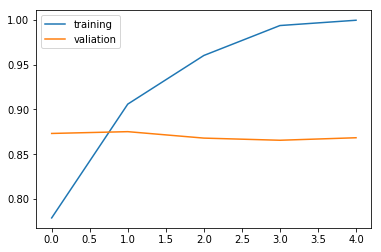

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

## 3.多核卷积网络

In [22]:
filter_sizes=[3,4,5]
def convolution():
    inn = layers.Input(shape=(sequence_length, embedding_dimension, 1))
    cnns = []
    for size in filter_sizes:
        conv = layers.Conv2D(filters=64, kernel_size=(size, embedding_dimension),
                            strides=1, padding='valid', activation='relu')(inn)
        pool = layers.MaxPool2D(pool_size=(sequence_length-size+1, 1), padding='valid')(conv)
        cnns.append(pool)
    outt = layers.concatenate(cnns)
    
    model = keras.Model(inputs=inn, outputs=outt)
    return model

def cnn_mulfilter():
    model = keras.Sequential([
        layers.Embedding(input_dim=num_features, output_dim=embedding_dimension,
                        input_length=sequence_length),
        layers.Reshape((sequence_length, embedding_dimension, 1)),
        convolution(),
        layers.Flatten(),
        layers.Dense(10, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
        
    ])
    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
    return model

model = cnn_mulfilter()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape_1 (Reshape)          (None, 300, 100, 1)       0         
_________________________________________________________________
model (Model)                (None, 1, 1, 192)         76992     
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1930      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [23]:
%%time
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 40s 2ms/sample - loss: 0.4740 - accuracy: 0.7557 - val_loss: 0.3136 - val_accuracy: 0.8724
Epoch 2/5
22500/22500 [==============================] - 40s 2ms/sample - loss: 0.2623 - accuracy: 0.8968 - val_loss: 0.2967 - val_accuracy: 0.8796
Epoch 3/5
22500/22500 [==============================] - 43s 2ms/sample - loss: 0.1840 - accuracy: 0.9350 - val_loss: 0.2893 - val_accuracy: 0.8868
Epoch 4/5
22500/22500 [==============================] - 40s 2ms/sample - loss: 0.1215 - accuracy: 0.9599 - val_loss: 0.3308 - val_accuracy: 0.8772
Epoch 5/5
22500/22500 [==============================] - 45s 2ms/sample - loss: 0.0694 - accuracy: 0.9806 - val_loss: 0.3699 - val_accuracy: 0.8848
CPU times: user 10min 52s, sys: 4.88 s, total: 10min 56s
Wall time: 3min 28s


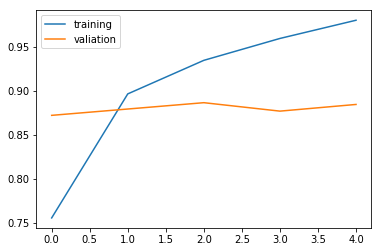

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()